In [1]:
import pandas as pd # for working with dataframes
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from pathlib import Path # for retrieving files from directory
import networkx as nx # for making graphs
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg # for images
from scipy.interpolate import interp1d # for interpolating points
from scipy.spatial import procrustes # for Procrustes analysis
from sklearn.decomposition import PCA # for principal component analysis
import seaborn as sns# ; sns.set(color_codes=True) # for plotting in seaborn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from sklearn.model_selection import StratifiedKFold # for Stratified K fold sampling
from sklearn.cluster import AgglomerativeClustering # for agglomerative clustering
import scipy.stats as stats # for kruskal wallis test
import statsmodels.stats.multitest as multitest # multiple test adjustment


# Check tracing

In [2]:
data_dir = "./leaves/" # set data directory
file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
file_names.remove('.DS_Store') # remove .DS_Store file
file_names.sort() # sort the list of file names
file_names # check list of file names

page_numbers = [] # get the page of the illustration
for i in range(len(file_names)):
    page_numbers.append(file_names[i][:file_names[i].index("_")])

plant_numbers = [] # get the individual plant
for i in range(len(file_names)):
    plant_numbers.append(file_names[i][file_names[i].index("_")+1:file_names[i].rfind("_")])

page_plant_IDs = [] # get page_plant_IDs
for i in range(len(file_names)):
    page_plant_IDs.append(file_names[i][:file_names[i].rfind("_")])

In [3]:
lo = "k" # leaf outline color
w = 0.5 # outline width
alfa = 1 # alpha

pic_dir = "./pics/" # set the directory of the pictures
save_dir = "./check/" # set the directory where to save image checks

unique_page_nums = list(set(page_numbers)) # get unique page numbers

for j in range(len(unique_page_nums)): # for each page
    print(j)

    curr_page = unique_page_nums[j] # get current page
    
    curr_image = pic_dir + curr_page + ".png" # get the current image to plot on
    
    plt.figure(figsize=(8.5,11)) # set figure size
    
    img = mpimg.imread(curr_image) # read in current image
    plt.imshow(img)
    
    for i in range(len(file_names)): # plot each leaf
        if curr_page in file_names[i]:
            lf = np.loadtxt(data_dir + file_names[i])
            plt.plot(lf[:,0], lf[:,1], c="k", lw=w)
            plt.fill(lf[:,0], lf[:,1], alpha=alfa)

    plt.savefig(save_dir+curr_page+".png") # save plot
    plt.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


# Procrustes Analysis

In [4]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean

In [5]:
# how many pseudo-landmarks
res = 200

# get page number and plant ID for each leaf
pg_num_list = []
pl_num_list = []
pl_ID_list = []

# an array to store pseudo-landmarks
lf_arr = np.zeros((len(file_names),res,2))

for i in range(len(file_names)): # for each leaf
    
    #############################################
    ### READ IN DATA AND RETRIEVE INFORMATION ###
    #############################################

    name = file_names[i] # get current file name

    pg_num_list.append(page_numbers[i]) # get the page of the illustration
    pl_num_list.append(plant_numbers[i]) # get the individual plant
    pl_ID_list.append(page_plant_IDs[i]) # get the page_plant_ID

    lf_coords = np.loadtxt(data_dir + name) # load in leaf coordinates

    ###################################
    ### SPECIFY BASE AND TIP POINTS ###
    ###################################

    base_pt = lf_coords[0]
    tip_pt = lf_coords[-1]

    ###################
    ### INTERPOLATE ###
    ###################

    x_vals, y_vals = interpolation(lf_coords[:,0],lf_coords[:,1], res)
    lf_arr[i,:,:] = np.column_stack((x_vals, y_vals))

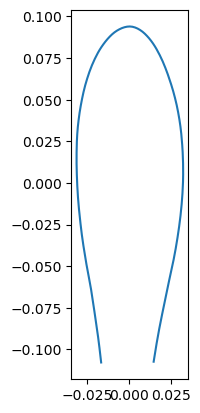

In [6]:
landmark_num = res # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(lf_arr, landmark_num, dim_num)

pca = PCA(n_components=2) # perform PCA to align along longest axis
pca = pca.fit_transform(mean_shape)

rot_x, rot_y = rotate_points(pca[:,0], pca[:,1], 180) # rotate mean leaf upwards
rot_mean = np.column_stack((rot_x, rot_y))

plt.plot(rot_mean[:,0], rot_mean[:,1]) # plot mean leaf
plt.gca().set_aspect("equal")

Text(0.5, 1.0, 'overall mean leaf')

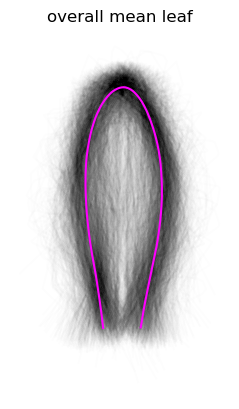

In [7]:
################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(lf_arr)) 

for i in range(len(lf_arr)):
    s1, s2, distance = procrustes(rot_mean, lf_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array

for i in range(len(proc_arr)):
    plt.plot(proc_arr[i,:,0], proc_arr[i,:,1], c="k", alpha=0.007)

plt.plot(np.mean(proc_arr, axis=0)[:,0], np.mean(proc_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("overall mean leaf")


# Morphospace

In [8]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = res*2 # PC number = res*2
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )

PC: var, overall 
PC1: 31.6%, 31.6%
PC2: 28.8%, 60.4%
PC3: 12.5%, 72.9%
PC4: 8.1%, 81.0%
PC5: 5.4%, 86.4%
PC6: 2.7%, 89.1%
PC7: 2.1%, 91.2%
PC8: 1.6%, 92.9%
PC9: 1.1%, 93.9%
PC10: 0.8%, 94.7%
PC11: 0.7%, 95.3%
PC12: 0.5%, 95.8%
PC13: 0.4%, 96.3%
PC14: 0.4%, 96.6%
PC15: 0.3%, 97.0%
PC16: 0.3%, 97.3%
PC17: 0.3%, 97.6%
PC18: 0.2%, 97.8%
PC19: 0.2%, 98.0%
PC20: 0.2%, 98.2%
PC21: 0.2%, 98.4%
PC22: 0.2%, 98.6%
PC23: 0.2%, 98.7%
PC24: 0.1%, 98.8%
PC25: 0.1%, 99.0%
PC26: 0.1%, 99.1%
PC27: 0.1%, 99.2%
PC28: 0.1%, 99.3%
PC29: 0.1%, 99.3%
PC30: 0.1%, 99.4%
PC31: 0.1%, 99.5%
PC32: 0.1%, 99.5%
PC33: 0.0%, 99.6%
PC34: 0.0%, 99.6%
PC35: 0.0%, 99.6%
PC36: 0.0%, 99.7%
PC37: 0.0%, 99.7%
PC38: 0.0%, 99.7%
PC39: 0.0%, 99.7%
PC40: 0.0%, 99.8%
PC41: 0.0%, 99.8%
PC42: 0.0%, 99.8%
PC43: 0.0%, 99.8%
PC44: 0.0%, 99.8%
PC45: 0.0%, 99.8%
PC46: 0.0%, 99.9%
PC47: 0.0%, 99.9%
PC48: 0.0%, 99.9%
PC49: 0.0%, 99.9%
PC50: 0.0%, 99.9%
PC51: 0.0%, 99.9%
PC52: 0.0%, 99.9%
PC53: 0.0%, 99.9%
PC54: 0.0%, 99.9%
PC55: 0.0%, 99.9

In [9]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 10 # select number for reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# create dataframe for plotting
mdata = pd.DataFrame({
    "page":pg_num_list,
    "plant":pl_num_list,
    "ID":pl_ID_list,
})

# add the PCs to the dataframe
for i in range(PC_NUMBER):
    mdata["PC"+str(i+1)] = PCs[:,i]

PC: var, overall 
PC1: 31.6%, 31.6%
PC2: 28.8%, 60.4%
PC3: 12.5%, 72.9%
PC4: 8.1%, 81.0%
PC5: 5.4%, 86.4%
PC6: 2.7%, 89.1%
PC7: 2.1%, 91.2%
PC8: 1.6%, 92.9%
PC9: 1.1%, 93.9%
PC10: 0.8%, 94.7%


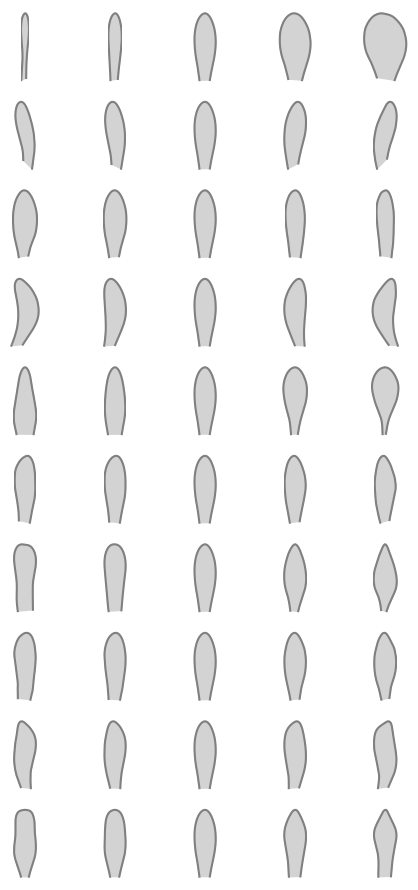

In [10]:
###################################################
### CREATE EIGEN REPRESENTATIONS OF FIRST 2 PCs ###
###################################################

# calculate standard deviations for each PC
stdev_list = [] # list to store standard deviations for each PC
for i in range(PC_NUMBER):
    stdev_list.append(mdata["PC"+str(i+1)].std())

# create an array of PC values to reconstruct
# for each PC_NUMBER
# calculate PC_NUMBER values
# for each standard deviation value in sdev_vals
sdev_vals = [-2,-1,0,1,2] # standard deviation values to calculate
PC_vals = np.zeros((PC_NUMBER,PC_NUMBER,5)) # an array of PC values to evaluate
for i in range(PC_NUMBER): # for the ith PC
    for j in range(len(sdev_vals)): # for each standard deviation position
        PC_vals[i,i,j] = sdev_vals[j]*stdev_list[i]

# Plot
plt.figure(figsize=(5,9))

counter = 1

for i in range(np.shape(PC_vals)[0]):
    for j in range(len(sdev_vals)):
    
        # create inverse leaf
        inv_leaf = pca.inverse_transform(np.array(PC_vals[i,:,j]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot inverse leaf
        plt.subplot(PC_NUMBER,len(sdev_vals),counter)
        plt.fill(inv_x, inv_y, c="lightgray")
        plt.plot(inv_x, inv_y, c="gray")
        plt.gca().set_aspect("equal")
        plt.axis("off")
        
        counter += 1

plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Procrustean morphospace\n41 plants, 1751 leaves')

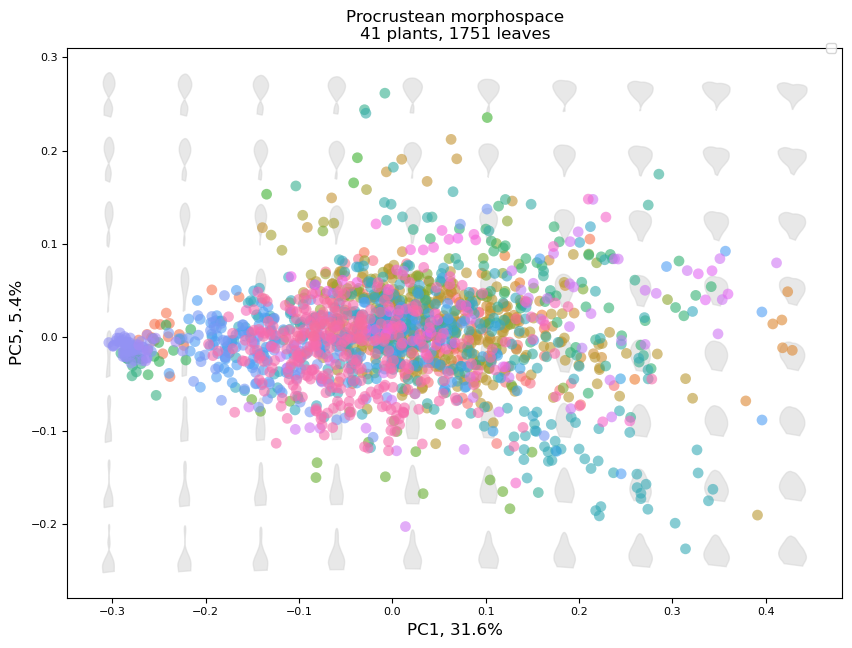

In [11]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPCa = 10 # set number of PCa intervals
numPCb = 8 # set number of PCb intervals
hue = "ID" # select the factor to color by
s = 0.2 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 60 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace\n" + str(len(mdata["ID"].unique())) + " plants, " + str(len(PCs)) + " leaves" # set title

### Set PC index values to plot
##########################
PCa = 0 # index position of first PC
PCb = 4 # index position of second PC
##########################

PCa_vals = np.linspace( np.min(PCs[:,PCa]), np.max(PCs[:,PCa]), numPCa ) # create PC intervals
PCb_vals = np.linspace( np.min(PCs[:,PCb]), np.max(PCs[:,PCb]), numPCb )

plt.figure(figsize=(plot_length, plot_width))

for i in PCa_vals: # for each PCa interval
    for j in PCb_vals: # for each PCb interval
        
        pca_val = i # select the current PCa val
        pcb_val = j # select the current PCb val

        eigen_arr = np.zeros((PC_NUMBER)) # create an array for eigenleaf, length of number of PCs
        eigen_arr[PCa] = pca_val # set the PCa value
        eigen_arr[PCb] = pcb_val # set the PCb value
        
        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(eigen_arr)
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pca_val, inv_y*s+pcb_val, c=lf_col, alpha=lf_alpha)

# plot the data on top of the morphospace
sns.scatterplot(data=mdata, x="PC"+str(PCa+1), y="PC"+str(PCb+1), hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha, legend=False)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC"+str(PCa+1)+", " + str(round(pca.explained_variance_ratio_[PCa]*100,1)) + "%"
ylab = "PC"+str(PCb+1)+", " + str(round(pca.explained_variance_ratio_[PCb]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.gca().set_axisbelow(True)
plt.title(title)

# Linear Discriminant Analysis

In [12]:
# create a df for LDA by genotype
geno_df = pd.DataFrame(data=flat_arr[:,:])

# add the genotype labels
geno_df["geno"] = mdata["ID"]

# create input and output variables
X = geno_df.iloc[:,0:400]
y = geno_df["geno"]

# initialize the LDA model
geno_model = LinearDiscriminantAnalysis()

# create a StratifiedKFold object with k=4
skf = StratifiedKFold(n_splits=4)

# initialize an empty confusion matrix
cm = np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int)

# perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the LDA model on the training data
    geno_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = geno_model.predict(X_test)

    # Update the confusion matrix
    cm += confusion_matrix(y_test, y_pred)

# normalize 
norm_cm = np.zeros(np.shape(cm))

for i in range(len(cm)):
    row_sum = np.sum(cm[i,:])
    norm_cm[i,:] = cm[i,:]/row_sum



Text(975.5277777777779, 0.5, 'True class')

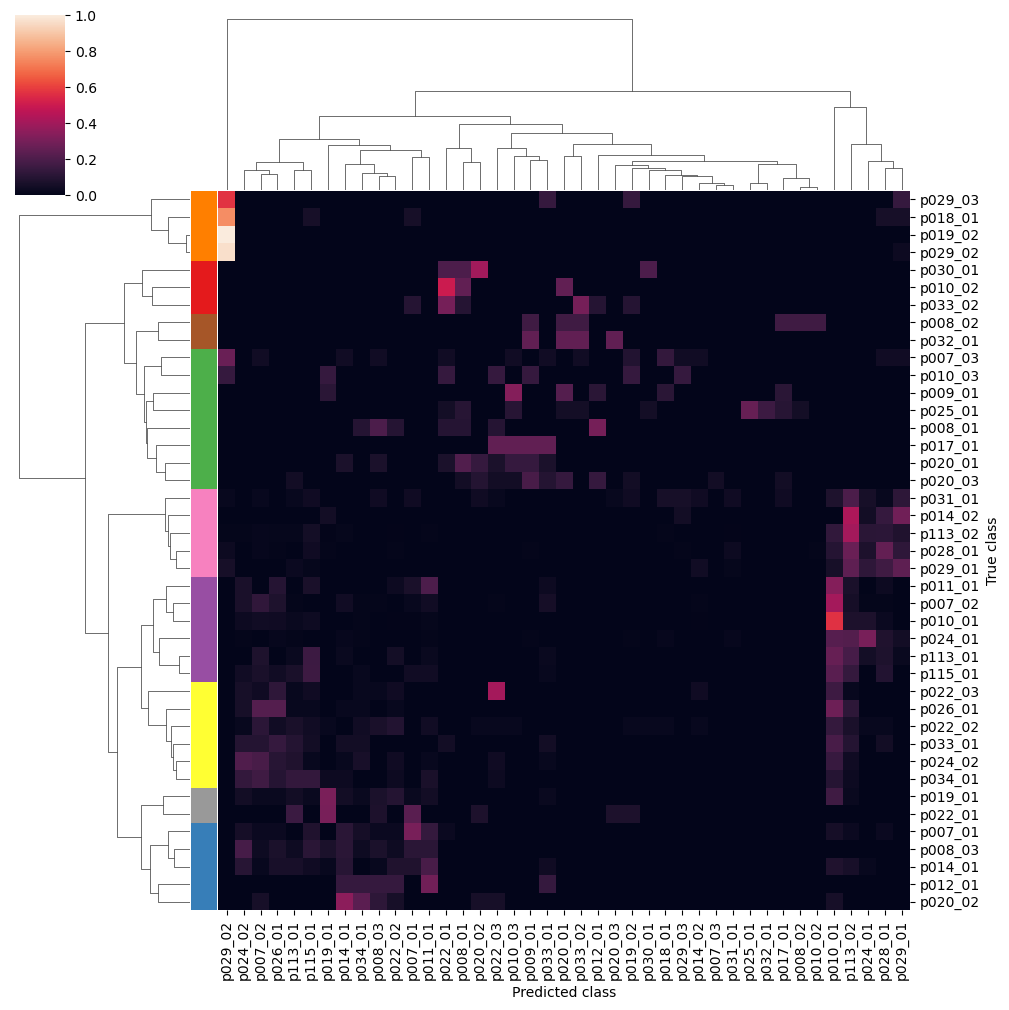

In [13]:
# Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=9, linkage='ward')
clustering.fit(norm_cm)

# Retrieve cluster labels
labels = clustering.labels_
label_df = pd.DataFrame(labels, columns=["label"])

# Retrieve classes
geno_classes = geno_model.classes_

# Create cluster colors
#lut = dict(zip(set(labels), sns.husl_palette(len(set(labels)), l=0.7, s=1, h=0.5)))
lut = dict(zip(set(labels), sns.color_palette("Set1")))
row_colors = pd.DataFrame(labels)[0].map(lut)

# Plot
g=sns.clustermap(norm_cm, 
                 col_cluster=True,  
                 row_colors=[row_colors],
                 xticklabels=geno_classes,
                 yticklabels=geno_classes,
                 method="ward"
                )

ax = g.ax_heatmap
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")

In [14]:
LDA_cluster_df = pd.DataFrame({"ID":geno_classes, "cluster":labels, "color":row_colors})

In [15]:
df_LDA = pd.merge(mdata, LDA_cluster_df, on='ID', how='left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Procrustean morphospace\n41 plants, 1751 leaves')

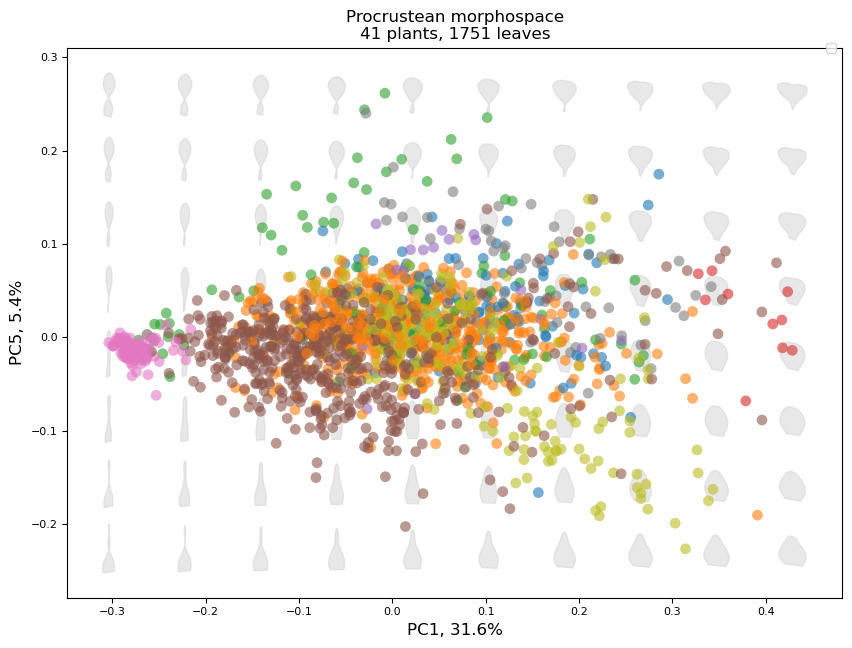

In [16]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPCa = 10 # set number of PCa intervals
numPCb = 8 # set number of PCb intervals
hue = "color" # select the factor to color by
s = 0.2 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 60 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace\n" + str(len(mdata["ID"].unique())) + " plants, " + str(len(PCs)) + " leaves" # set title

### Set PC index values to plot
##########################
PCa = 0 # index position of first PC
PCb = 4 # index position of second PC
##########################

PCa_vals = np.linspace( np.min(PCs[:,PCa]), np.max(PCs[:,PCa]), numPCa ) # create PC intervals
PCb_vals = np.linspace( np.min(PCs[:,PCb]), np.max(PCs[:,PCb]), numPCb )

plt.figure(figsize=(plot_length, plot_width))

for i in PCa_vals: # for each PCa interval
    for j in PCb_vals: # for each PCb interval
        
        pca_val = i # select the current PCa val
        pcb_val = j # select the current PCb val

        eigen_arr = np.zeros((PC_NUMBER)) # create an array for eigenleaf, length of number of PCs
        eigen_arr[PCa] = pca_val # set the PCa value
        eigen_arr[PCb] = pcb_val # set the PCb value
        
        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(eigen_arr)
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pca_val, inv_y*s+pcb_val, c=lf_col, alpha=lf_alpha)

# plot the data on top of the morphospace
sns.scatterplot(data=df_LDA, x="PC"+str(PCa+1), y="PC"+str(PCb+1), hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha, legend=False)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC"+str(PCa+1)+", " + str(round(pca.explained_variance_ratio_[PCa]*100,1)) + "%"
ylab = "PC"+str(PCb+1)+", " + str(round(pca.explained_variance_ratio_[PCb]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.gca().set_axisbelow(True)
plt.title(title)

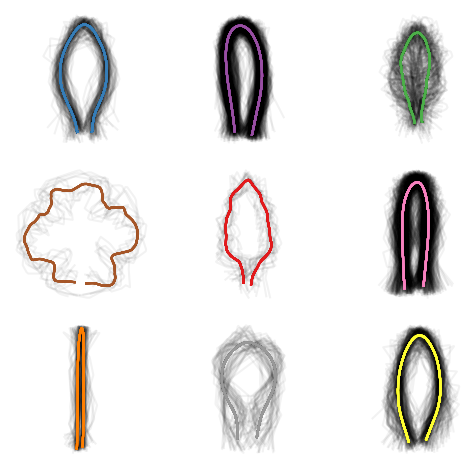

In [17]:
unique_clusters = df_LDA["cluster"].unique()

for i in range(len(unique_clusters)):

    masked_df = df_LDA[df_LDA["cluster"]==unique_clusters[i]].reset_index()
    
    curr_col = masked_df["color"].iloc[0]
    indices = masked_df["index"]
    
    group_mean = np.mean(proc_arr[indices], axis=0)
    
    for j in range(len(indices)):

        plt.subplot(3,3,i+1)
        plt.plot(proc_arr[indices[j],:,0], proc_arr[indices[j],:,1], alpha=0.05, c="k")
        plt.plot(group_mean[:,0],group_mean[:,1], c=curr_col)
        plt.axis("off")
        plt.gca().set_aspect("equal")
    plt.tight_layout()
        

# Procrustes distance significant difference classification

In [18]:
unique_plants = list(set(y)) # create a list of unique plants

group1_names = [] # a list to store group1 names
group2_names = [] # a list to store group2 names
p_vals = [] # a list to store pvals

for i in range(len(unique_plants)):

    if i%10==0:
        print(i)
        
    for j in range(len(unique_plants)):

        inds_i = np.where(y==unique_plants[i]) # get indices of plant i 
        inds_j = np.where(y==unique_plants[j]) # get indices of plant j
        
        # get leaf coords for plant i
        coords_i = X.iloc[inds_i] 
        i_arr = np.array(coords_i)
        i_arr = np.reshape(i_arr, (np.shape(i_arr)[0], 200, 2))
        
        # get leaf coords for plant j
        coords_j = X.iloc[inds_j] 
        j_arr = np.array(coords_j)
        j_arr = np.reshape(j_arr, (np.shape(j_arr)[0], 200, 2))
        
        # get all leaf coordinates
        all_arr = np.row_stack((i_arr, j_arr))
        
        mean_i = np.mean(i_arr, axis=0) # get mean leaf for plant i
        mean_j = np.mean(j_arr, axis=0) # get mean leaf for plant j
        mean_both = np.mean(np.row_stack((i_arr, j_arr)), axis=0) # get mean of leaves from both plants
        
        # calculate Procrustes distance of each leaf to respective group mean
        group1_dists = []
        for k in range(len(i_arr)):
            s1, s2, distance = procrustes( i_arr[k,:,:], mean_i ) 
            group1_dists.append(distance)
        
        group2_dists = []
        for l in range(len(j_arr)):
            s1, s2, distance = procrustes( j_arr[l,:,:], mean_j) 
            group2_dists.append(distance)
        
        # concatenate arrays to group means
        group_dists = np.array(group1_dists+group2_dists)
        
        # calculate Procrustes distance of each leaf to overall mean
        all_dists = []
        for m in range(len(all_arr)):
            s1, s2, distance = procrustes(all_arr[m,:,:], mean_both) 
            all_dists.append(distance)
        all_dists = np.array(all_dists)
        
        # calculate p value
        statistic, p_value = stats.kruskal(group_dists, all_dists)

        # save data
        group1_names.append(unique_plants[i])
        group2_names.append(unique_plants[j])
        p_vals.append(p_value)

# Adjust p-values using the FDR BH correction
BH_pvals = multitest.multipletests(p_vals, method='fdr_bh', alpha=0.05)

# create a matrix for clustermap
group_df = pd.DataFrame({

    "group1":group1_names,
    "group2":group2_names,
    "significant":BH_pvals[0],
    "BH":BH_pvals[1]
})

inv_group_df = pd.DataFrame({
    "group1":group2_names,
    "group2":group1_names,
    "significant":BH_pvals[0],
    "BH":BH_pvals[1]
})


pairwise_df = pd.concat([group_df, inv_group_df]).reset_index()

matrix = (pairwise_df.pivot_table(index='group1', columns='group2', values='BH')
   .fillna(1, downcast='infer')
)




0
10
20
30
40


Text(905.5555555555557, 0.5, 'Plant')

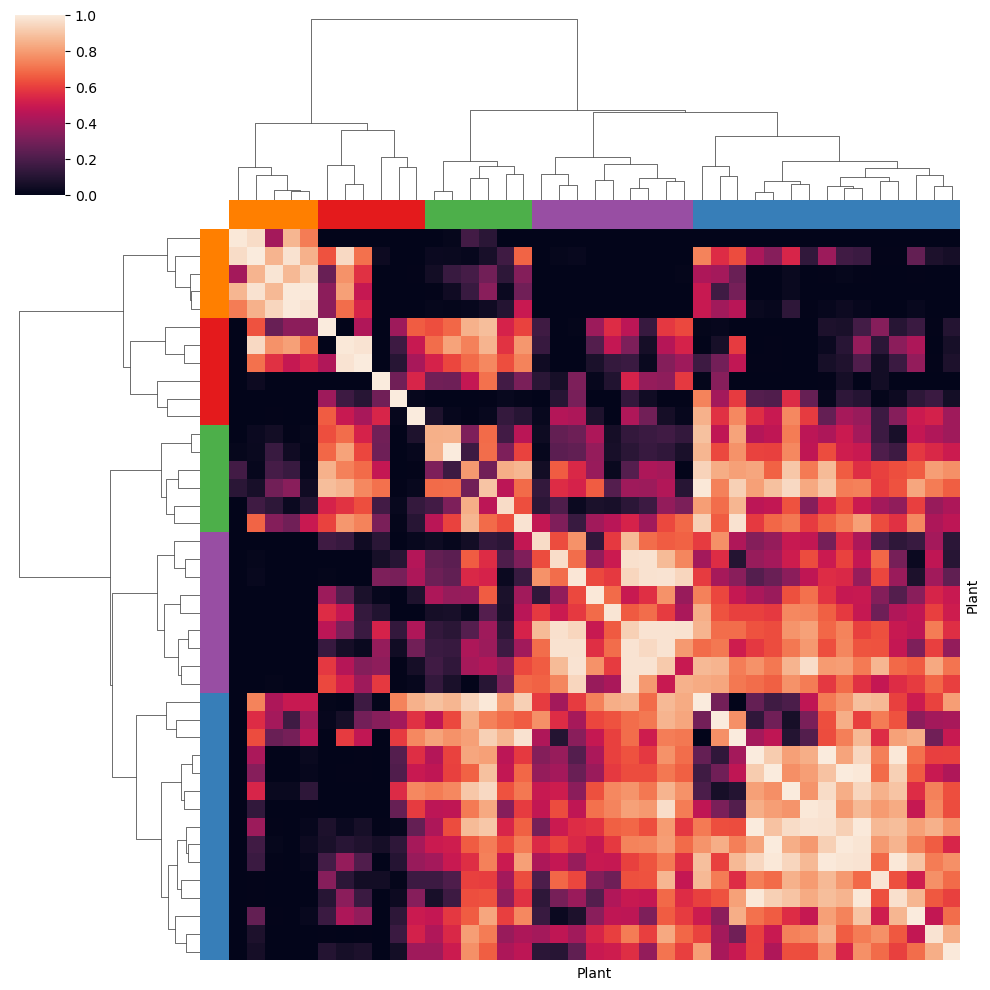

In [19]:
# Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')
clustering.fit(matrix)

# Retrieve cluster labels
labels = clustering.labels_
label_df = pd.DataFrame(labels, columns=["label"])

# Create cluster colors
#lut = dict(zip(set(labels), sns.husl_palette(len(set(labels)), l=0.7, s=1, h=0.5)))
lut = dict(zip(set(labels), sns.color_palette("Set1")))
row_colors = pd.DataFrame(labels)[0].map(lut)

# Plot
g = sns.clustermap(matrix,
                   row_colors=[row_colors],
                   col_colors=[row_colors],
                   method="ward",
                   xticklabels=False,
                   yticklabels=False
                  )

ax = g.ax_heatmap
ax.set_xlabel("Plant")
ax.set_ylabel("Plant")


In [20]:
proc_cluster_df = pd.DataFrame({"ID":unique_plants, "cluster":labels, "color":row_colors})

In [21]:
df_proc = pd.merge(mdata, proc_cluster_df, on='ID', how='left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Procrustean morphospace\n41 plants, 1751 leaves')

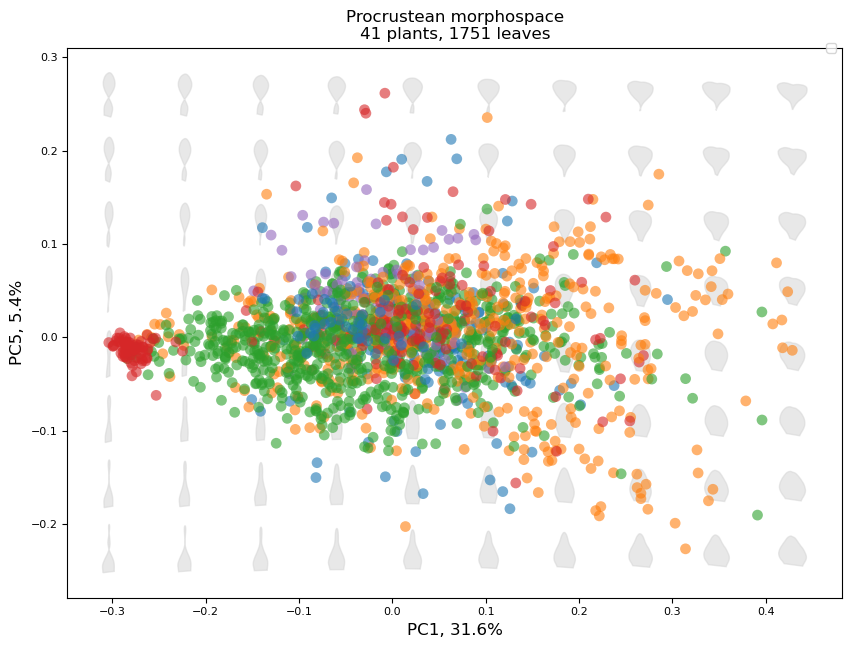

In [22]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPCa = 10 # set number of PCa intervals
numPCb = 8 # set number of PCb intervals
hue = "color" # select the factor to color by
s = 0.2 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 60 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace\n" + str(len(mdata["ID"].unique())) + " plants, " + str(len(PCs)) + " leaves" # set title

### Set PC index values to plot
##########################
PCa = 0 # index position of first PC
PCb = 4 # index position of second PC
##########################

PCa_vals = np.linspace( np.min(PCs[:,PCa]), np.max(PCs[:,PCa]), numPCa ) # create PC intervals
PCb_vals = np.linspace( np.min(PCs[:,PCb]), np.max(PCs[:,PCb]), numPCb )

plt.figure(figsize=(plot_length, plot_width))

for i in PCa_vals: # for each PCa interval
    for j in PCb_vals: # for each PCb interval
        
        pca_val = i # select the current PCa val
        pcb_val = j # select the current PCb val

        eigen_arr = np.zeros((PC_NUMBER)) # create an array for eigenleaf, length of number of PCs
        eigen_arr[PCa] = pca_val # set the PCa value
        eigen_arr[PCb] = pcb_val # set the PCb value
        
        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(eigen_arr)
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pca_val, inv_y*s+pcb_val, c=lf_col, alpha=lf_alpha)

# plot the data on top of the morphospace
sns.scatterplot(data=df_proc, x="PC"+str(PCa+1), y="PC"+str(PCb+1), hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha, legend=False)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC"+str(PCa+1)+", " + str(round(pca.explained_variance_ratio_[PCa]*100,1)) + "%"
ylab = "PC"+str(PCb+1)+", " + str(round(pca.explained_variance_ratio_[PCb]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.gca().set_axisbelow(True)
plt.title(title)